In [2]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from transformer_onestep_CL import GPTClosedLoop
import tqdm
import argparse

In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [4]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [5]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [6]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [7]:
torch.cuda.is_available()

True

In [8]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_lin_CL_v4.pt", map_location=device)

In [9]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [10]:
# del exp_data["model_args"]['use_pi']

In [11]:
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model_CL = GPTClosedLoop(gptconf).to(device)

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_CL.load_state_dict(state_dict)
model = model_CL.gpt_model

number of parameters: 0.11M


In [12]:
exp_data.keys()

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

In [13]:
exp_data['best_val_loss']

0.0016236203955486417

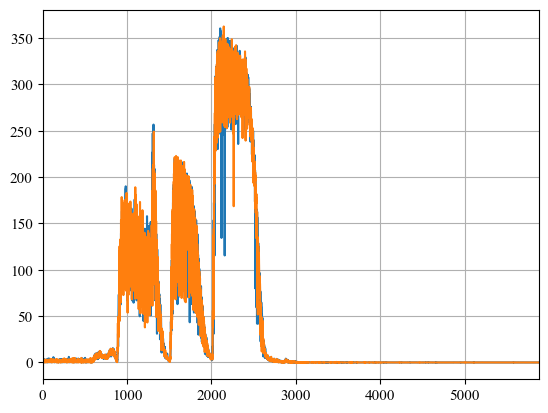

In [14]:
plt.plot(exp_data['LOSS'])
plt.plot(exp_data['LOSS_VAL'])
# plt.xlim([0, 2000])

In [15]:
exp_data['train_time'] / 3600

18.869751559495924

In [16]:
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, drss_matrices
set_seed(42) 

seq_len = 300  
nx = 2
nu = 1
ny = 1
 
# define settings
ts = 1e-2  

# define nominal model
G = drss_matrices(nx, nu, ny, device=device)

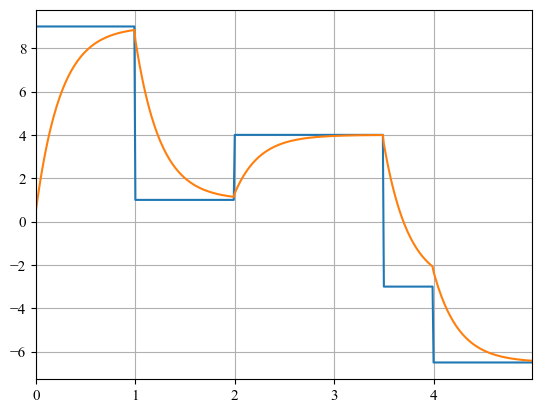

In [17]:
T = 5
t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)
r = torch.ones_like(t, device=device, dtype=torch.float32)


r[(t < 1)] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 2) & (t < 3.5)] = np.random.choice(np.arange(-10,10,.5))#-5
r[(t >= 3.5) & (t < 4)] = np.random.choice(np.arange(-10,10,.5))#0
r[(t >= 4) & (t < 5)] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 5.0) & (t < 7.5)] = np.random.choice(np.arange(-10,10,.5))#0
r[(t >= 7.5) & (t < 10)] = np.random.choice(np.arange(-10,10,.5))#1
r[(t >= 10.) & (t < 12.5)] = np.random.choice(np.arange(-10,10,.5))#-1
r[(t >= 12.5) & (t < 15.)] = np.random.choice(np.arange(-10,10,.5))#10
r[(t >= 15.0) & (t < 17.5)] = np.random.choice(np.arange(-10,10,.5))#0
r[(t >= 17.5) & (t < 20.0)] = np.random.choice(np.arange(-10,10,.5))#-10

tau = 1
M_num = torch.tensor([0.01, 1], device=device, dtype=torch.float32)  # Numerator coefficients
M_den = torch.tensor([tau/4, 1], device=device, dtype=torch.float32)  # Denominator coefficients
M = tf2ss(M_num, M_den, device=device)
M_d = c2d(*M, ts, device=device)
y_d = forced_response(*M_d, r)

plt.plot(t.cpu().numpy(), r.cpu().numpy())
plt.plot(t.cpu().numpy(), y_d.cpu().numpy())

In [18]:
print(model.proportional_coefficient)
print(model.integral_coefficient)
print(model.derivative_coefficient)

Parameter containing:
tensor([1.1680], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.7391], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.5550], device='cuda:0', requires_grad=True)


In [19]:
import pickle as pkl
H = 500

with open("test_linear_systems.pkl", "rb") as f:
    G_dict = pkl.load(f)

n_test = 10    
E_log = np.zeros((n_test, len(t)))
U_log = np.zeros((n_test, len(t)))
Y_log = np.zeros((n_test, len(t)))

for key, G in G_dict.items():
    
    E = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    U = torch.empty(t.size(0)+1, device=device, dtype=torch.float32).reshape(1,-1,1)
    Y = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    
    with torch.no_grad():
        # initial
        U[0,0,0] = 0
        y_i = 0
        x_i = torch.zeros(nx, device=device, dtype=torch.float32)
        
        for i in range(len(t)):
            
            # print('time instant:', i)
            # start the loop with error
            e_i = r[i] - y_i
                
            Y[0,i,0] = y_i
            E[0,i,0] = e_i
            
            # Controller u(t) = C(e(t),u(t-1))
            if i < H:
                pred = model(E[:, :i+1, :], U[:, :i+1, :])
            else:
                pred = model(E[:, i-H+1:i+1, :], U[:, i-H+1:i+1, :])
                
            U[0,i+1,0] = pred[0,-1,0] # just for coherence, it could be directly be u_i_prev
            
            y, x_i = forced_response(*G, U[0,i:i+2,:] , return_x=True, x0=x_i)
            
            y_i = y[-1]
            
    E_log[key] = E[0,:,0].cpu().numpy()
    U_log[key] = U[0,1:,0].cpu().numpy()
    Y_log[key] = Y[0,:,0].cpu().numpy()
    
    if key == n_test-1:
        break

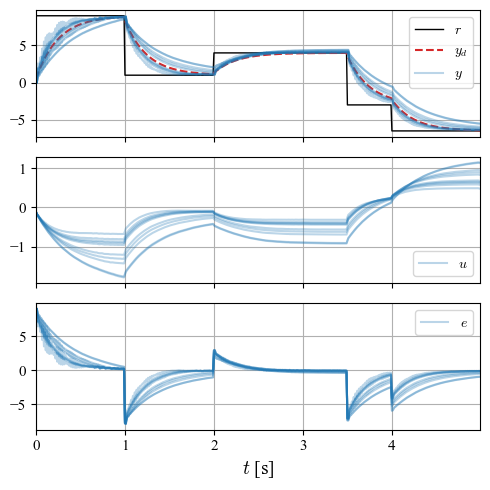

In [24]:
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t.cpu().numpy(), r.cpu().numpy(), label="$r$", c='k', linewidth=1)
plt.plot(t.cpu().numpy(), y_d.cpu().numpy(), label=None, c='tab:red', alpha=1, linestyle='--')
plt.plot(t.cpu().numpy(), Y_log.T, c='tab:blue', alpha=.3)
plt.legend(['$r$','$y_d$','$y$'], loc='upper right')
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t.cpu().numpy(), U_log.T, c='tab:blue', alpha=.3)
plt.legend(['$u$'], loc='lower right')
# plt.xlim([10, 12])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t.cpu().numpy(), E_log.T, c='tab:blue', alpha=.3)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$e$'], loc='upper right')

# plt.savefig('transformer_controller.pdf')
# Improve the layout to avoid overlapping
plt.tight_layout()

plt.show()